Put on hold as lfilter drops the imaginary part of the values which is different to matlab filter

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import mlab
from scipy.signal import butter, freqz, lfilter, spectrogram

In [3]:
# Load in file to pandas dataframe
df = pd.read_table(
    "C:/Users/macka/Google Drive/Level-4-Project/data/raw/Dataset_97.dat",
    sep="\n",
    header=None)

In [4]:
# Switches out i for j to ensure python compatibility
def convert_to_complex(complex_string):
    return complex(complex_string[0].replace('i', 'j'))

In [5]:
# Grab RADAR settings from top of file
center_frequency = float(df.iloc[0])
sweep_time = float(df.iloc[1])/1000  # convert to seconds
number_of_time_samples = float(df.iloc[2])
bandwidth = float(df.iloc[3])
sampling_frequency = number_of_time_samples/sweep_time
record_length = 60
number_of_chirps = record_length/sweep_time

In [7]:
print(center_frequency, sweep_time, number_of_time_samples, bandwidth, sampling_frequency, record_length, number_of_chirps)

5800000000.0 0.001 128.0 400000000.0 128000.0 60 60000.0


In [6]:
# Put data values into an array
data = df.iloc[4:]
data = data.apply(convert_to_complex, axis=1)
data = data.values

In [8]:
# Reshape into chirps over time
data_time = np.reshape(data, (int(number_of_chirps),int(number_of_time_samples)))
data_time = np.rot90(data_time, k=3)

In [9]:
print(data[:2])
print("\n")
print(data_time[0,:2])

[2045.+2060.j 2020.+2082.j]


[2039.+2052.j 2040.+2051.j]


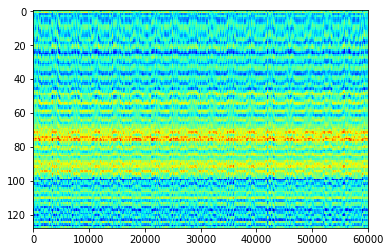

In [10]:
plt.imshow(abs(data_time),cmap='jet', aspect="auto")

In [11]:
# Does nothing (copied from original matlab file)
win = np.ones((int(number_of_time_samples), data_time.shape[1]))

In [12]:
# Apply fast fourier transform
fft_applied = np.fft.fft((data_time * win), axis=0)

In [13]:
print(fft_applied.shape)
print(fft_applied[0:2, :2]) # different from matlab

(128, 60000)
[[261535.        +262453.j         261537.        +262460.j        ]
 [ -1783.67191363   -450.91418394j  -1768.85477615   -468.05422979j]]


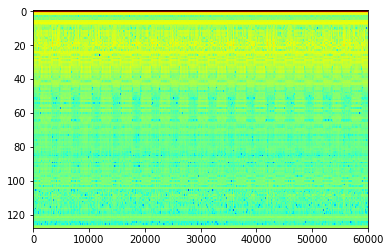

In [57]:
plt.imshow(20*(np.log10(abs(fft_applied))),cmap='jet', aspect="auto")


In [14]:
# shift fft
fft_shifted = np.fft.fftshift(fft_applied, axes=(0,))

C:\Users\macka\Anaconda3\envs\dataScience\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


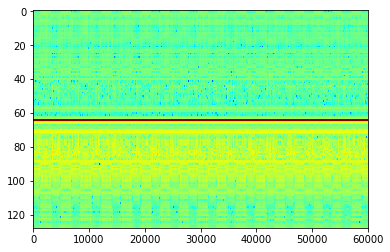

In [58]:
plt.imshow(20*(np.log10(abs(fft_shifted))),cmap='jet', aspect="auto")


In [15]:
print(fft_shifted[0:2, :2])# fftshift switches bottom and top halves (64,0) is equal to (0,0) of original fft

[[-11.        +25.j           1.        +36.j        ]
 [-50.10944574-37.84673158j -46.95551248-42.57933395j]]


In [16]:
data_range = fft_shifted[int(number_of_time_samples/2):int(number_of_time_samples), :] # take top half

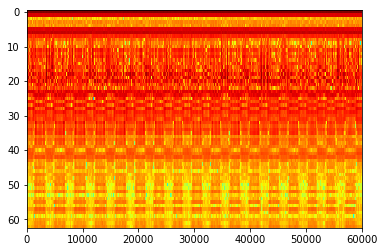

In [59]:
plt.imshow(20*(np.log10(abs(data_range))),cmap='jet', aspect="auto")
# maybe different?

In [17]:
print(data_range.shape)
print(data_range[1][0])

(64, 60000)
(-1783.6719136300767-450.9141839383552j)


In [18]:
def nearest_odd_number(x):
    if(np.floor(x) % 2 == 0):
        return int(np.floor(x) + 1)
    else:
        return int(np.floor(x))

In [19]:
# IIR Notch filter
x = data_range.shape[1]
ns = nearest_odd_number(x) - 1

In [20]:
print(ns)

60000


In [21]:
data_range_MTI = np.zeros((data_range.shape[0], ns), dtype=np.complex128)

In [22]:
data_range_MTI.shape

(64, 60000)

In [23]:
(b, a) = butter(4, 0.01, btype="high") # made a filter remove DC component and very low frequency components

In [24]:
print(b, a)

[ 0.95978223 -3.83912892  5.75869338 -3.83912892  0.95978223] [ 1.         -3.91790787  5.75707638 -3.76034951  0.92118193]


In [25]:
(f1, h) = freqz(b, a, ns)

In [26]:
print(f1, h)

[0.00000000e+00 5.23598776e-05 1.04719755e-04 ... 3.14143557e+00
 3.14148793e+00 3.14154029e+00] [-1.18712144e-10+0.00000000e+00j -4.74844288e-10+2.01816381e-12j
 -7.12246027e-10+6.18486026e-12j ...  1.00000000e+00+3.22408008e-06j
  1.00000000e+00+2.14938672e-06j  1.00000000e+00+1.07469336e-06j]


In [27]:
for i in range(data_range.shape[0]):
    data_range_MTI[i, :ns] = lfilter(b, a, data_range[i, :ns], axis=0)
#     print(data_range_MTI[i, :ns])

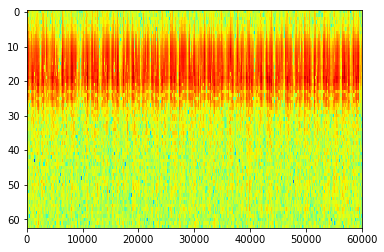

In [63]:
plt.imshow(20*(np.log10(abs(data_range_MTI))),cmap='jet', aspect="auto")


In [28]:
print(data_range_MTI.shape)
print(data_range_MTI[63][0]) 
print(data_range_MTI[62][0]) 
print(data_range_MTI[0][0]) 
print(data_range_MTI[1][0]) 


# plt.pcolormesh(20 * np.log10(np.abs(data_range_MTI)))


(64, 60000)
(59.597447306010245-38.176676972276134j)
(10.949213496332383-59.81100634666293j)
(251016.64554586596+251897.72563308603j)
(-1711.9366070078474-432.7794210383219j)


In [29]:
freq = np.arange(0, ns-1)
freq = freq * sampling_frequency/(2*ns)

In [30]:
print(freq)

[0.00000000e+00 1.06666667e+00 2.13333333e+00 ... 6.39957333e+04
 6.39968000e+04 6.39978667e+04]


In [31]:
range_axis = (freq * 3e8*sweep_time)/(2*bandwidth)

In [32]:
data_range_MTI = data_range_MTI[1:, :]
data_range = data_range[1:, :]

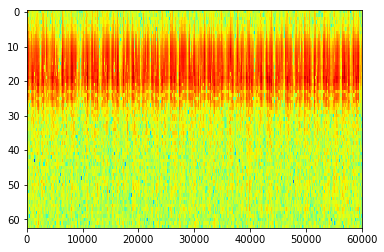

In [64]:
plt.imshow(20*(np.log10(abs(data_range_MTI))),cmap='jet', aspect="auto")

In [33]:
print(data_range_MTI[0])

[-1711.93660701-432.77942104j -1557.17885137-413.70234598j
 -1442.0685462 -365.00669424j ...    13.37784708 +25.92245955j
    -5.65012201 +20.30787937j     6.86425948 +17.33304654j]


In [34]:
print(data_range_MTI.shape)

(63, 60000)


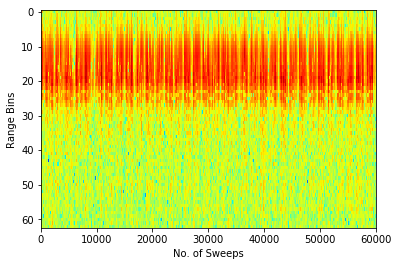

In [35]:
plt.xlabel("No. of Sweeps")
plt.ylabel("Range Bins")
plt.imshow(20 * np.log10(abs(data_range_MTI)),cmap='jet', aspect="auto")


In [65]:
bin_indl = 5
bin_indu = 25
MD = {}
MD["PRF"] = 1/sweep_time
MD["TimeWindowLength"] = 200
MD["OverlapFactor"] = 0.95
MD["OverlapLength"] = np.round(MD["TimeWindowLength"] * MD["OverlapFactor"])
MD["Pad_Factor"] = 4
MD["FFTPoints"] = MD["Pad_Factor"]*MD["TimeWindowLength"]
MD["DopplerBin"] = MD["PRF"]/MD["FFTPoints"]
MD["DopplerAxis"] = np.arange(-MD["PRF"]/2, MD["PRF"]/2-MD["DopplerBin"]+1, MD["DopplerBin"])               
MD["WholeDuration"] = data_range_MTI.shape[1]/MD["PRF"]

MD["NumSegments"] = np.floor(
    (data_range_MTI.shape[1]-MD["TimeWindowLength"])/
    (np.floor(MD["TimeWindowLength"]*(1-MD["OverlapFactor"])))
)

In [66]:
print(MD["FFTPoints"])

800


In [91]:
data_spec_MTI2=0
for rbin in range(bin_indl-1, bin_indu):
    print(rbin)
    
    s, f, t = mlab.specgram(data_range_MTI[rbin, :],
                            Fs=1,
                            window=np.hamming(MD["TimeWindowLength"]),
                            noverlap=MD["OverlapLength"],
                            NFFT=MD["TimeWindowLength"], 
                            mode='complex',
                            pad_to=MD["FFTPoints"] )
#     plt.imshow(20 * np.log10(abs(s)),cmap='jet', aspect="auto")
    
#     print(s.shape)
    data_MTI_temp = np.fft.fftshift(s, 1)
#     plt.imshow(20 * np.log10(abs(data_MTI_temp)),cmap='jet', aspect="auto")
#     break
#     print(data_MTI_temp.shape)
    data_spec_MTI2=data_spec_MTI2+abs(data_MTI_temp);                                


4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [92]:
print(data_spec_MTI2.shape)

(800, 5981)


In [93]:
MD["TimeAxis"] = np.linspace(0,MD["WholeDuration"], data_spec_MTI2.shape[1])

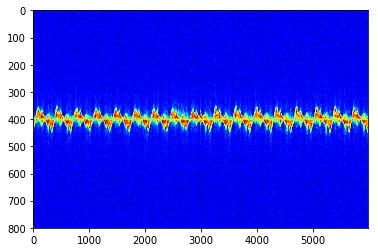

In [94]:
plt.imshow(20 * np.log10(abs(data_spec_MTI2)),cmap='jet', aspect="auto")

In [95]:
# data_spec_MTI2 = np.flipud(data_spec_MTI2/np.max(data_spec_MTI2[:]))

In [96]:
print(data_spec_MTI2.shape)
print(MD["TimeAxis"].shape, MD["DopplerAxis"].shape, (20*np.log10(abs(data_spec_MTI2))).shape)

(800, 5981)
(5981,) (800,) (800, 5981)


In [97]:
print(data_spec_MTI2.shape)

(800, 5981)


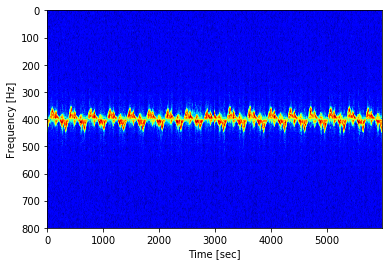

In [98]:
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

plt.imshow(20*(np.log10(abs(data_spec_MTI2))),cmap='jet', aspect="auto")


In [99]:
print(MD["TimeAxis"].shape, MD["DopplerAxis"].shape)
print(data_spec_MTI2[0:3, 0:3])

(5981,) (800,)
[[14.39237076 14.29185141 15.21305521]
 [14.67424935 14.08850557 14.02652766]
 [15.29427308 14.36669245 14.12731441]]


Text(0, 0.5, 'Doppler [Hz]')

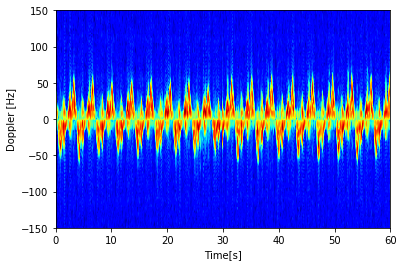

In [102]:
plt.pcolormesh(MD["TimeAxis"], MD["DopplerAxis"],20 * np.log10(np.abs(data_spec_MTI2)),cmap='jet')
plt.ylim([-150, 150])
plt.xlabel("Time[s]")
plt.ylabel("Doppler [Hz]")